# gradB drift

In [1]:
import numpy as np
from scipy.integrate import RK45, solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [24]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 150
plt.rcParams["image.cmap"] = "jet"

In [25]:
CHARGE = 1.0
MASS = 1.0
Bz0 = 10
dBzdr = -1

In [26]:
def calc_mfield(position):
    r = np.linalg.norm(position[:2])
    return np.array([0, 0, Bz0 + dBzdr * r])

def eq_motion_RHS(t, velocity, position):
	m = MASS
	q = CHARGE
	mfield = calc_mfield(position=position)
	f = np.cross(velocity, mfield)
	return f * q / m

def runge_kutta(f, t0, x0, v0, te, h):
    ts = np.arange(t0, te, h)
    xs = []
    vs = []
    x = x0
    v = v0
    for t in tqdm(ts):
        xs.append(x)
        vs.append(v)
        k1 = f(t, v, x)
        l1 = v

        k2 = f(t + h/2, v + h/2*k1, x + h/2*l1)
        l2 = v + h/2*k1

        k3 = f(t + h/2, v + h/2*k2, x + h/2*l2)
        l3 = v + h/2*k2

        k4 = f(t + h, v + h*k3, x + h*l3)
        l4 = v + h*k3
        
        v = v + (k1 + 2*k2 + 2*k3 + k4)/6*h
        x = x + (l1 + 2*l2 + 2*l3 + l4)/6*h

    return (ts, np.array(xs))

In [27]:
x_unique, y_unique = np.linspace(-5, 5, 501), np.linspace(-5, 5, 501)
xx, yy = np.meshgrid(x_unique, y_unique)

100%|██████████| 501/501 [00:02<00:00, 182.64it/s]


Text(0, 0.5, 'y')

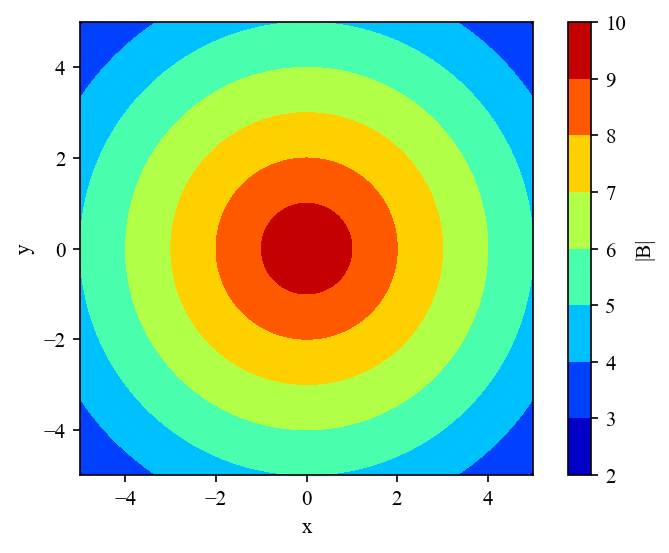

In [28]:
bb = np.zeros_like(xx)
for i in tqdm(range(len(x_unique))):
	for j in range(len(y_unique)):
		position = np.array([x_unique[i], y_unique[j], 0])
		bb[i, j] = np.linalg.norm(calc_mfield(position=position))


fig = plt.figure(facecolor="white")
ax = fig.add_subplot(111)
ax.set_aspect("equal")

mappable = ax.contourf(xx, yy, bb)
plt.colorbar(mappable=mappable, label="|B|")
ax.set_xlabel("x")
ax.set_ylabel("y")

100%|██████████| 31416/31416 [00:07<00:00, 4105.45it/s]


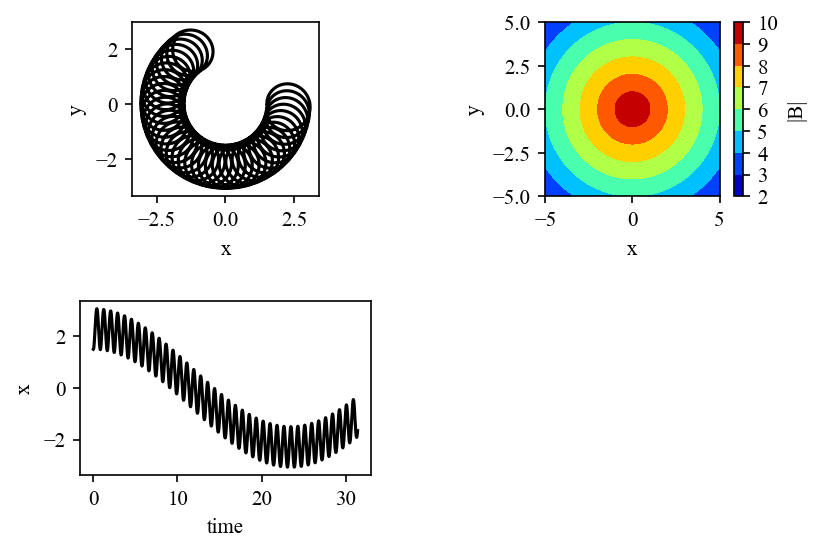

In [29]:
init_position = np.array([1.5, 0, 0])
v0 = 6
init_velocity = np.array([0, v0, 0])

rama_radius = MASS * v0 / (CHARGE * Bz0)
period = 2 * np.pi * rama_radius / v0
ts, positions = runge_kutta(f=eq_motion_RHS, t0=0, x0=init_position, v0=init_velocity, te=period*50, h=1e-3)

xs = positions[:, 0]
ys = positions[:, 1]

fig = plt.figure(facecolor="white")
plt.subplots_adjust(wspace=0.4, hspace=0.6)
ax1 = fig.add_subplot(221)
ax1.set_aspect("equal")

ax1.plot(xs, ys, color="black")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2 = fig.add_subplot(222)
ax2.set_aspect("equal")
mappable = ax2.contourf(xx, yy, bb)
plt.colorbar(mappable=mappable, label="|B|")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

ax3 = fig.add_subplot(223)
ax3.set_xlabel("time")
ax3.set_ylabel("x")
xs = ts
ys = positions[:, 0]
ax3.plot(xs, ys, color="black")

# 意図的にドリフトを作ってみる

100%|██████████| 1000/1000 [00:00<00:00, 794676.77it/s]


Text(0, 0.5, 'y')

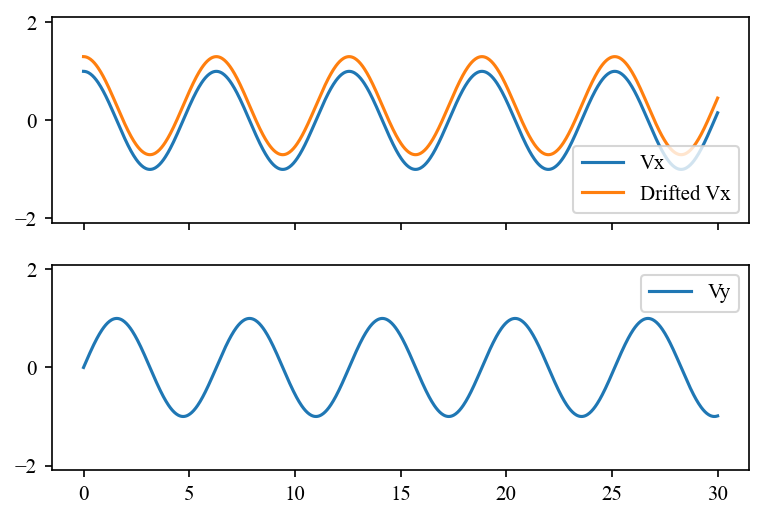

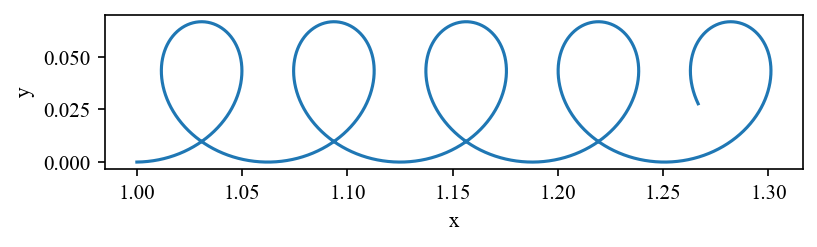

In [33]:
ts = np.linspace(0, 30, 1001)
vx = np.cos(ts)
vy = np.sin(ts)
v_drift = 0.3
vx_prime = vx + v_drift

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(ts, vx, label="Vx")
axes[1].plot(ts, vy, label="Vy")
axes[0].plot(ts, vx_prime, label="Drifted Vx")
for i, ax in enumerate(axes):
	ax.set_ylim([-2.1, 2.1])
	ax.legend()

xs, ys = np.zeros_like(vx), np.zeros_like(vy)
xs[0] = 1
ys[0] = 0

dt = 0.001
for i in tqdm(range(1, len(xs))):
	xs[i] = vx_prime[i] * dt + xs[i-1]
	ys[i] = vy[i] * dt + ys[i-1]


fig, ax = plt.subplots(1, 1)
ax.set_aspect("equal")
ax.plot(xs, ys)
ax.set_xlabel("x")
ax.set_ylabel("y")


## いろんなドリフト

100%|██████████| 1000/1000 [00:00<00:00, 726412.19it/s]


Text(0, 0.5, 'Vy')

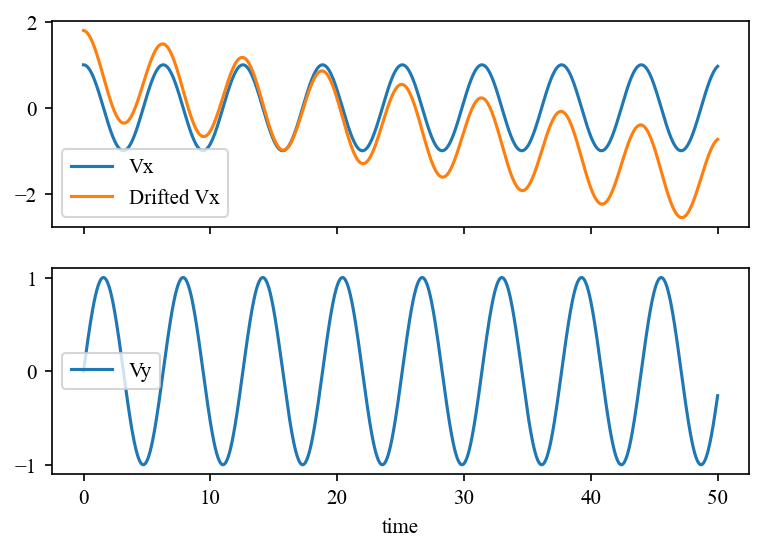

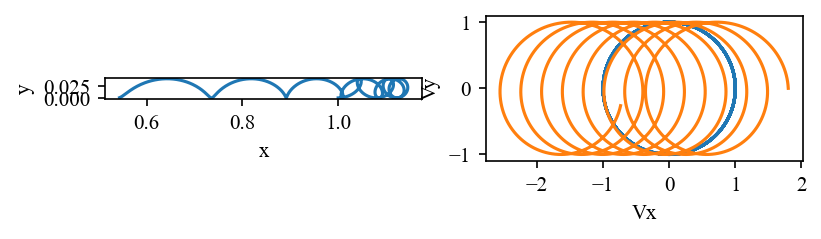

In [43]:
ts = np.linspace(0, 50, 1001)
vx = np.cos(ts)
vy = np.sin(ts)
v_drift = -0.05 * ts + 0.8
vx_prime = vx + v_drift

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(ts, vx, label="Vx")
axes[1].plot(ts, vy, label="Vy")
axes[0].plot(ts, vx_prime, label="Drifted Vx")
axes[1].set_xlabel("time")
for i, ax in enumerate(axes):
	ax.legend()

xs, ys = np.zeros_like(vx), np.zeros_like(vy)
xs[0] = 1
ys[0] = 0

dt = 0.001
for i in tqdm(range(1, len(xs))):
	xs[i] = vx_prime[i] * dt + xs[i-1]
	ys[i] = vy[i] * dt + ys[i-1]


fig, axes = plt.subplots(1, 2)
ax1, ax2 = axes
ax1.set_aspect("equal")
ax2.set_aspect("equal")
ax1.plot(xs, ys)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2.plot(vx, vy, label="Vx Vy")
ax2.plot(vx_prime, vy, label="Vx_prime Vy")
ax2.set_xlabel("Vx")
ax2.set_ylabel("Vy")

100%|██████████| 1000/1000 [00:00<00:00, 820963.79it/s]


Text(0, 0.5, 'Vy')

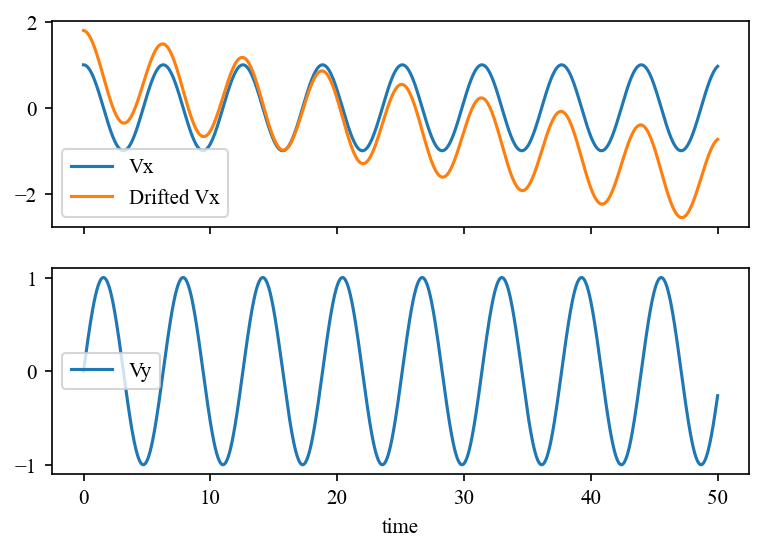

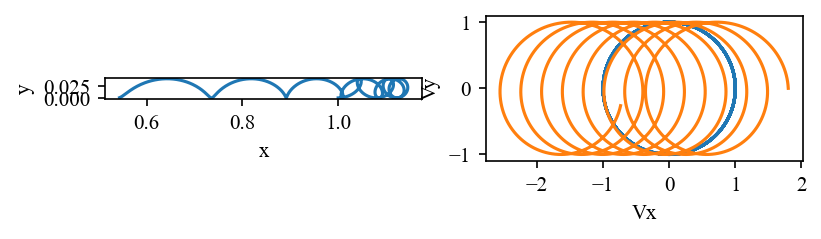

In [45]:
ts = np.linspace(0, 50, 1001)
vx = np.cos(ts)
vy = np.sin(ts)
v_drift = -0.05 * ts + 0.8
vx_prime = vx + v_drift

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(ts, vx, label="Vx")
axes[1].plot(ts, vy, label="Vy")
axes[0].plot(ts, vx_prime, label="Drifted Vx")
axes[1].set_xlabel("time")
for i, ax in enumerate(axes):
	ax.legend()

xs, ys = np.zeros_like(vx), np.zeros_like(vy)
xs[0] = 1
ys[0] = 0

dt = 0.001
for i in tqdm(range(1, len(xs))):
	xs[i] = vx_prime[i] * dt + xs[i-1]
	ys[i] = vy[i] * dt + ys[i-1]


fig, axes = plt.subplots(1, 2)
ax1, ax2 = axes
ax1.set_aspect("equal")
ax2.set_aspect("equal")
ax1.plot(xs, ys)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2.plot(vx, vy, label="Vx Vy")
ax2.plot(vx_prime, vy, label="Vx_prime Vy")
ax2.set_xlabel("Vx")
ax2.set_ylabel("Vy")

100%|██████████| 1000/1000 [00:00<00:00, 824190.21it/s]


Text(0, 0.5, 'Vy')

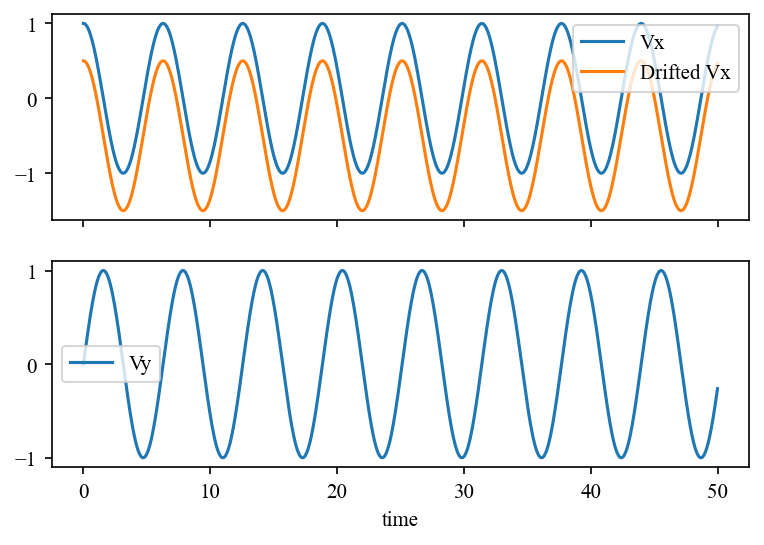

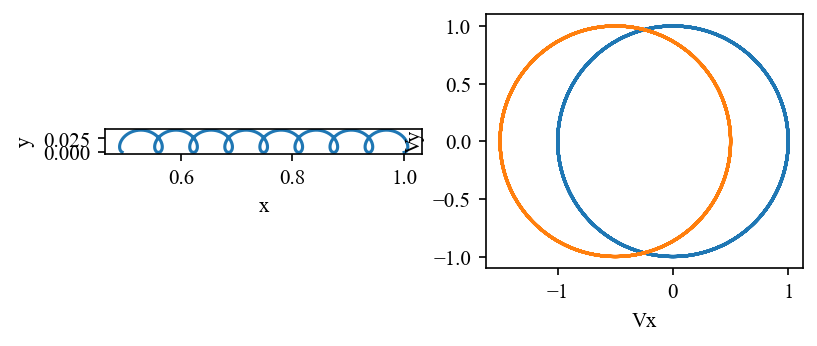

In [56]:
ts = np.linspace(0, 50, 1001)
vx = np.cos(ts)
vy = np.sin(ts)
v_drift = -0.5
vx_prime = vx + v_drift

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(ts, vx, label="Vx")
axes[1].plot(ts, vy, label="Vy")
axes[0].plot(ts, vx_prime, label="Drifted Vx")
axes[1].set_xlabel("time")
for i, ax in enumerate(axes):
	ax.legend()

xs, ys = np.zeros_like(vx), np.zeros_like(vy)
xs[0] = 1
ys[0] = 0

dt = 0.001
for i in tqdm(range(1, len(xs))):
	xs[i] = vx_prime[i] * dt + xs[i-1]
	ys[i] = vy[i] * dt + ys[i-1]


fig, axes = plt.subplots(1, 2)
ax1, ax2 = axes
ax2.set_aspect("equal")
ax1.set_aspect("equal")
ax1.plot(xs, ys)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2.plot(vx, vy, label="Vx Vy")
ax2.plot(vx_prime, vy, label="Vx_prime Vy")
ax2.set_xlabel("Vx")
ax2.set_ylabel("Vy")

100%|██████████| 1000/1000 [00:00<00:00, 779900.33it/s]


Text(0, 0.5, 'Vy')

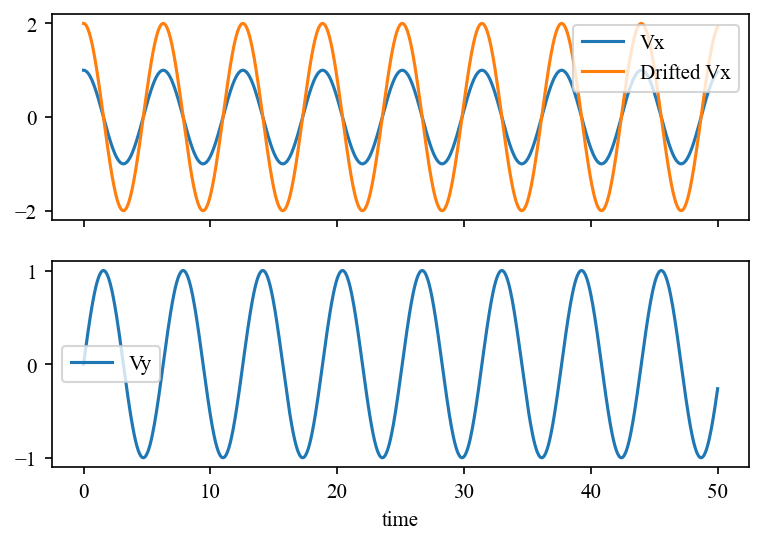

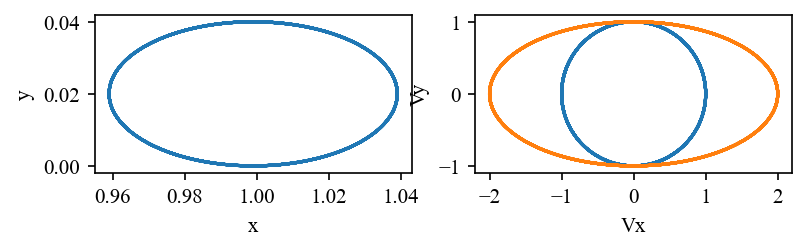

In [58]:
ts = np.linspace(0, 50, 1001)
vx = np.cos(ts)
vy = np.sin(ts)
v_drift = np.cos(ts) * 1
vx_prime = vx + v_drift

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(ts, vx, label="Vx")
axes[1].plot(ts, vy, label="Vy")
axes[0].plot(ts, vx_prime, label="Drifted Vx")
axes[1].set_xlabel("time")
for i, ax in enumerate(axes):
	ax.legend()

xs, ys = np.zeros_like(vx), np.zeros_like(vy)
xs[0] = 1
ys[0] = 0

dt = 0.001
for i in tqdm(range(1, len(xs))):
	xs[i] = vx_prime[i] * dt + xs[i-1]
	ys[i] = vy[i] * dt + ys[i-1]


fig, axes = plt.subplots(1, 2)
ax1, ax2 = axes
ax2.set_aspect("equal")
ax1.set_aspect("equal")
ax1.plot(xs, ys)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2.plot(vx, vy, label="Vx Vy")
ax2.plot(vx_prime, vy, label="Vx_prime Vy")
ax2.set_xlabel("Vx")
ax2.set_ylabel("Vy")

100%|██████████| 1000/1000 [00:00<00:00, 596290.02it/s]


Text(0, 0.5, 'Vy')

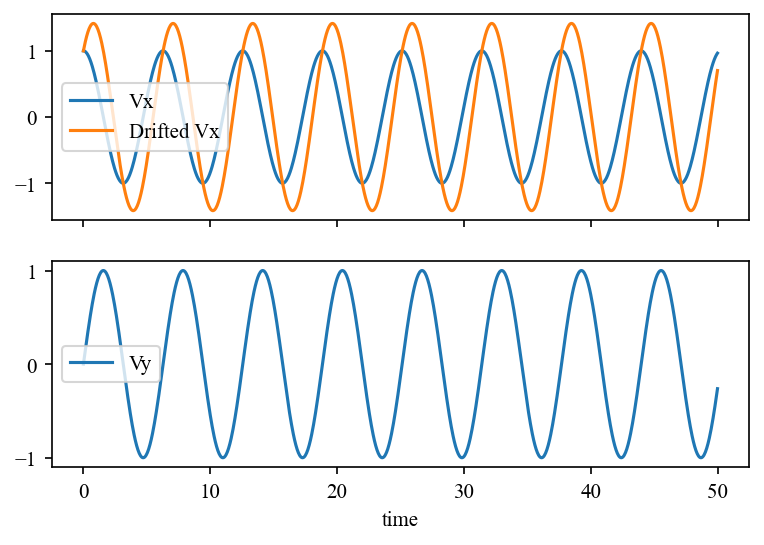

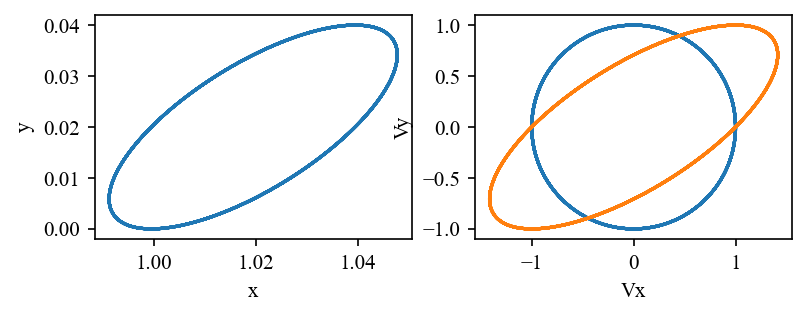

In [59]:
ts = np.linspace(0, 50, 1001)
vx = np.cos(ts)
vy = np.sin(ts)
v_drift = np.sin(ts) * 1
vx_prime = vx + v_drift

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(ts, vx, label="Vx")
axes[1].plot(ts, vy, label="Vy")
axes[0].plot(ts, vx_prime, label="Drifted Vx")
axes[1].set_xlabel("time")
for i, ax in enumerate(axes):
	ax.legend()

xs, ys = np.zeros_like(vx), np.zeros_like(vy)
xs[0] = 1
ys[0] = 0

dt = 0.001
for i in tqdm(range(1, len(xs))):
	xs[i] = vx_prime[i] * dt + xs[i-1]
	ys[i] = vy[i] * dt + ys[i-1]


fig, axes = plt.subplots(1, 2)
ax1, ax2 = axes
ax2.set_aspect("equal")
ax1.set_aspect("equal")
ax1.plot(xs, ys)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2.plot(vx, vy, label="Vx Vy")
ax2.plot(vx_prime, vy, label="Vx_prime Vy")
ax2.set_xlabel("Vx")
ax2.set_ylabel("Vy")

100%|██████████| 1000/1000 [00:00<00:00, 722532.99it/s]


Text(0, 0.5, 'Vy')

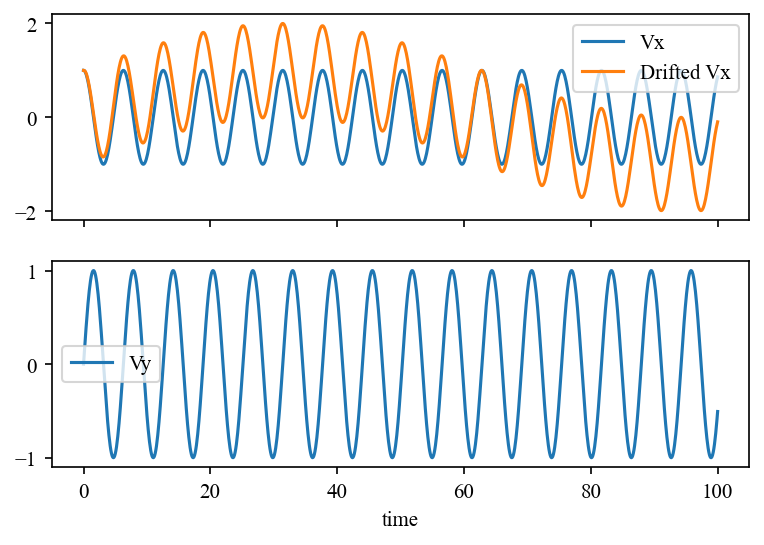

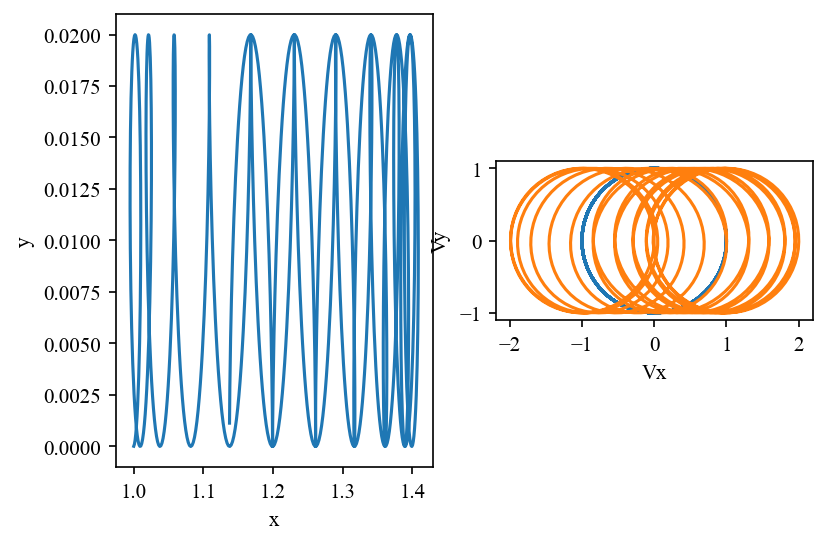

In [65]:
ts = np.linspace(0, 100, 1001)
vx = np.cos(ts)
vy = np.sin(ts)
v_drift = np.cos(ts / 20)
vx_prime = vx + v_drift

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(ts, vx, label="Vx")
axes[1].plot(ts, vy, label="Vy")
axes[0].plot(ts, vx_prime, label="Drifted Vx")
axes[1].set_xlabel("time")
for i, ax in enumerate(axes):
	ax.legend()

xs, ys = np.zeros_like(vx), np.zeros_like(vy)
xs[0] = 1
ys[0] = 0

dt = 0.001
for i in tqdm(range(1, len(xs))):
	xs[i] = vx_prime[i] * dt + xs[i-1]
	ys[i] = vy[i] * dt + ys[i-1]


fig, axes = plt.subplots(1, 2)
ax1, ax2 = axes
ax2.set_aspect("equal")
ax1.plot(xs, ys)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2.plot(vx, vy, label="Vx Vy")
ax2.plot(vx_prime, vy, label="Vx_prime Vy")
ax2.set_xlabel("Vx")
ax2.set_ylabel("Vy")

100%|██████████| 1000/1000 [00:00<00:00, 476300.70it/s]


Text(0, 0.5, 'Vy')

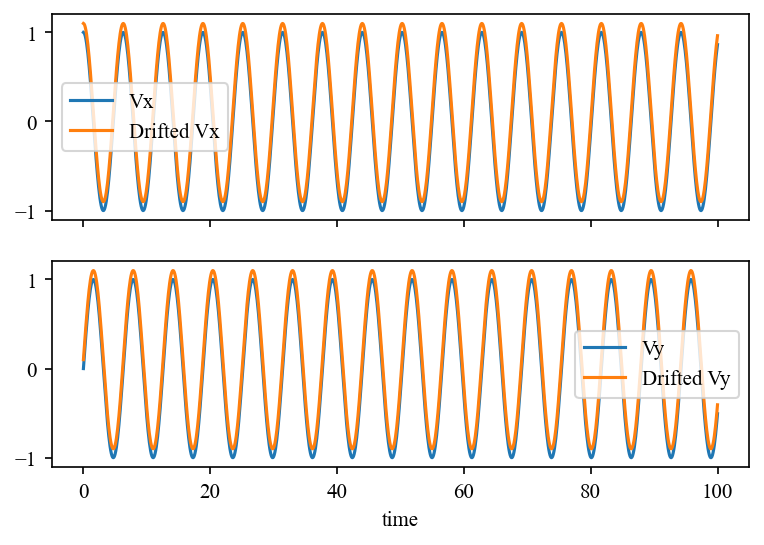

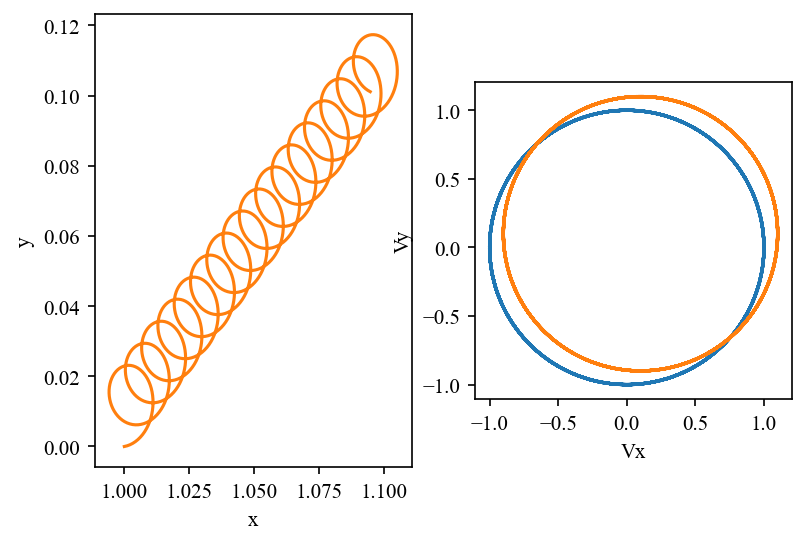

In [69]:
ts = np.linspace(0, 100, 1001)
vx = np.cos(ts)
vy = np.sin(ts)
v_drift = 0.1
vx_prime = vx + v_drift
vy_prime = vy + v_drift

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(ts, vx, label="Vx")
axes[1].plot(ts, vy, label="Vy")
axes[0].plot(ts, vx_prime, label="Drifted Vx")
axes[1].plot(ts, vy_prime, label="Drifted Vy")
axes[1].set_xlabel("time")
for i, ax in enumerate(axes):
	ax.legend()

xs, ys = np.zeros_like(vx), np.zeros_like(vy)
xs[0] = 1
ys[0] = 0

dt = 0.001
for i in tqdm(range(1, len(xs))):
	xs[i] = vx_prime[i] * dt + xs[i-1]
	ys[i] = vy_prime[i] * dt + ys[i-1]


fig, axes = plt.subplots(1, 2)
ax1, ax2 = axes
ax2.set_aspect("equal")
ax1.plot(xs, ys, color='#ff7f0e')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2.plot(vx, vy, label="Vx Vy")
ax2.plot(vx_prime, vy_prime, label="Vx_prime Vy")
ax2.set_xlabel("Vx")
ax2.set_ylabel("Vy")

100%|██████████| 1000/1000 [00:00<00:00, 648169.37it/s]


Text(0, 0.5, 'Vy')

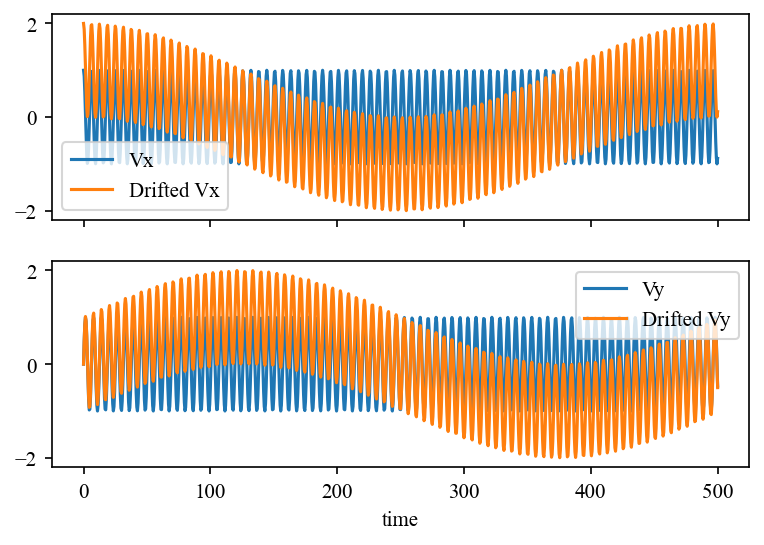

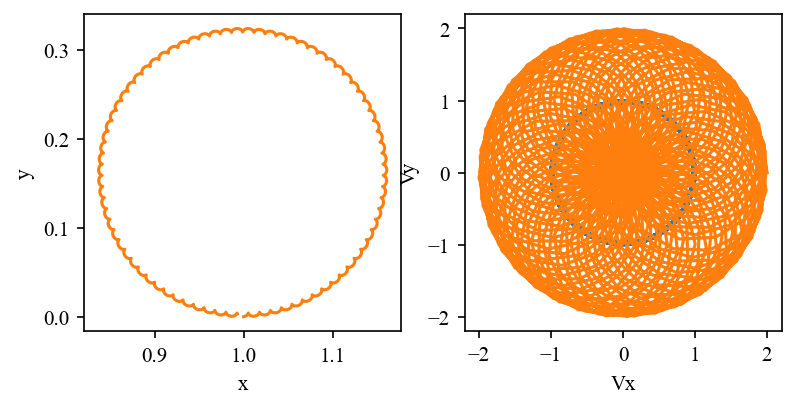

In [75]:
ts = np.linspace(0, 500, 1001)
vx = np.cos(ts)
vy = np.sin(ts)
vx_prime = vx + np.cos(ts / 80)
vy_prime = vy + np.sin(ts / 80)

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(ts, vx, label="Vx")
axes[1].plot(ts, vy, label="Vy")
axes[0].plot(ts, vx_prime, label="Drifted Vx")
axes[1].plot(ts, vy_prime, label="Drifted Vy")
axes[1].set_xlabel("time")
for i, ax in enumerate(axes):
	ax.legend()

xs, ys = np.zeros_like(vx), np.zeros_like(vy)
xs[0] = 1
ys[0] = 0

dt = 0.001
for i in tqdm(range(1, len(xs))):
	xs[i] = vx_prime[i] * dt + xs[i-1]
	ys[i] = vy_prime[i] * dt + ys[i-1]


fig, axes = plt.subplots(1, 2)
ax1, ax2 = axes
ax2.set_aspect("equal")
ax1.set_aspect("equal")
ax1.plot(xs, ys, color='#ff7f0e')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2.plot(vx, vy, label="Vx Vy")
ax2.plot(vx_prime, vy_prime, label="Vx_prime Vy")
ax2.set_xlabel("Vx")
ax2.set_ylabel("Vy")